# 1. Randomizációs módszerek
## Definíciók

In [29]:
import numpy as np
import cvxpy as cp # kvázi-konvex program
import matplotlib.pyplot as plt

Ellenőrző függvény

In [30]:
e =[0,0,0,0,0,0,0]
def check(par,e):
  if(par[0]**(-par[1]+par[4]) + par[0]**(-(3-2*par[1])+par[4]) > 1): e[0]+=1; return False # Step3 módosítások (f, n) 

  if(par[0]**(-1+par[5]) + par[0]**(-(1+par[1]-par[2]-par[5])) > 1): e[1]+=1; return False # Step3 módosítások (f, n)

  if(par[0]**(-1-par[5]) + par[0]**(-2) + par[0]**(-(2+par[1]-par[2])) > 1) : e[2]+=1;return False # 3.1.
  if(par[0]**(-1) + par[0]**(-2-par[5]) + par[0]**(-(2+par[1]-par[2]))) > 1: e[2]+=1;return False # Step3 módosítások (f, n) 3.2.
  if(par[0]**(-1-par[4]) + par[0]**(-2) + par[0]**(-(2+par[1]-par[2])) > 1) : e[2]+=1;return False # 3.3.

  if(par[0]**(-par[3]) + par[0]**(-(par[3]+2*par[2])) > 1): e[3]+=1;return False # alap
  if(par[0]**(-par[3]) + par[0]**(-(par[3]+par[2])) + par[0]**(-(par[3]+3*par[2])) > 1): e[4]+=1;return False # alap
  if(par[0]**(-par[3]) + par[0]**(-(par[3]+par[2])) + par[0]**(-(par[3]+2*par[2])) + par[0]**(-(par[3]+4*par[2])) > 1): e[5]+=1;return False # alap
  if(par[0]**(-par[3]) + par[0]**(-(par[3]+5*min(1-par[1],par[2]-par[3]))) > 1): e[6]+=1;return False # alap
  return True
  

Algoritmus futtatása sokszor

In [31]:
def iteration(algorithm,perturb,check,d,eps,delta,maxcnt,parameters,out,ins,bool=True,onlybestplot=False,specpars=None):
  plots=[]
  if(onlybestplot):
    bests=[3]
  else:
    bests=[]
  for _ in range(out): # a külső ciklusban mindent újrakezdünk
    plot=[parameters]
    best=[3,0,0,0,0,0]
    tpar=parameters.copy() # ne írja át mindig az eredeti változót
    for _ in range(ins): # a belső ciklusban az előző eredményből indulunk, ha az javított
      result=algorithm(tpar,perturb,check, d, eps, delta, maxcnt,bool,specpars)
      if(result[0][0]<=best[0]): 
        plot= plot+result[1]
        best=result[0]
        tpar=best
    # belső ciklus vége
    if(not onlybestplot): # ha nem csak a legjobb kell, akkor mindet feljegyezzük
      bests.append(best)
      plots.append(plot)
    else:
      if(best[0]<bests[0]):
        bests=best
        plots=plot
  # külső ciklus vége
  opt=[3]
  if(not onlybestplot):
    for i in bests:
      if(i[0]<opt[0]):opt=i
    return [opt,bests,plots]
  else:
    if(bests[0]<opt[0]):opt=bests
    return [opt,bests,[plots]]

Preparameter tuning

In [32]:
def pretune(d,eps,delta,maxcnt,alg,check,perturb,param,ifplot=False,onlybestplot=False,specpars=None):
    bestparam=[3]
    plots=[]
    for i in d:
        for e in eps:
            for j in delta:
                for c in maxcnt:
                    res=iteration(alg,perturb,check,i,e,j,c,param,1,1,False,onlybestplot,specpars)
                    if(ifplot):
                      if (not onlybestplot):
                        plots.append(res[2])
                      if (res[0][0]<bestparam[-1]):
                        bestparam=[i,e,j,c,res[0][0]]
                        if(onlybestplot):
                            plots=res[2]
                    else:
                        if (res[0][0]<bestparam[-1]):
                            bestparam=[i,e,j,c,res[0][0]]
    if(not ifplot):
        return bestparam
    else:
        return [bestparam,plots]

## 1.1 Minden változót egyszerre randomizálva

### Randomizáló függvény

In [57]:
def perturb1(parameters, d, specpars=None):
  outp=parameters.copy()
  if specpars==None:
    for i in range(0,len(parameters)):
      outp[i]=parameters[i] + np.random.uniform(-d,d)
  else:
    for i in range(0,len(parameters)):
      if(i in specpars):
        outp[i]=parameters[i] + np.random.uniform(-d,d)
  return outp

In [34]:
def checkall(temp):
    return (0<=temp[0]<=3 and 0<=temp[1]<= 1 and 0<=temp[2] <= 1 and 0<=temp[3] <= 1 and 1>=temp[4] >= 0 and 1>=temp[5] >= 0 
      and temp[1] > temp[2] and temp[2] > temp[3] and check(temp,e))

### Algoritmus 1.1.1.

In [68]:
def algorithm11(parameters,perturb,checkall, d, eps, delta, maxcnt,ifcnt0=False,specpars=None):
  outp=parameters.copy()
  plot=[]
  cnt = 0
  while(d>eps):
    temp = perturb(outp, d,specpars)
    if (checkall(temp)):
      outp=temp.copy()
      plot.append(temp.copy())
      if(ifcnt0): cnt= 0
    else: cnt+=1
    if(cnt >= maxcnt): d = d*delta; cnt = 0
  return [outp,plot]

### Paraméterek

In [36]:
parameters=[2,1,1,1,0,0]
names=["λ","alpha","beta","gamma","nu","mu"]
d=0.1
eps=1e-3
delta=0.2
maxcnt=1e4

In [37]:
check(parameters,e) # ellenőrzés

True

### Algoritmus futtatása

Ha a változók felsőkorlátja vagy alsókorlátja éppen a kezdeti érték, akkor nem talál megoldást. Ha fölvisszük nagy értékkel, akkor lassúnak bizonyul. Megoldás lehet csak egy darabig engedni az algoritmut, hogy elszálljanak az értékei, és utána újrakezdeni a jelenlegi d értékkel. Ehhez egy Lagrange-szerű enyhítő függvény lehet megoldás.

### Relaxált

In [38]:
def lagrange(parameters):
    l = 0 
    for i in range(1,4):
        if(parameters[i]>1): l+=(parameters[i]-1)
    return l

### Algoritmus 1.1.2

In [39]:
def algorithm12(parameters,perturb,che, d, eps, delta, maxcnt,ifcnt0=True,specpars=None):
  outp=parameters.copy()
  plot=[]
  cnt = 0
  while(d>eps):
    if lagrange(outp)>1:
      outp=parameters.copy()
    temp = perturb(outp, d,specpars)
    if (0<temp[0]<3 and 0<temp[1]< 2 and 0<temp[2] < 2 and 0<temp[3] < 2 and 1>temp[4] > 0 and 1>temp[5] > 0 
      and temp[1] > temp[2] and temp[2] > temp[3] and check(temp,e)):
      outp=temp.copy()
      plot.append(temp.copy())
      if(ifcnt0==True): cnt= 0
    else: cnt+=1
    if(cnt >= maxcnt): d = d*delta; cnt = 0
  return [outp,plot]

### Az algoritmus futtatása

Prerun haszálatával itt még nem ad jó eredményt

In [40]:
from itertools import product

def addhynames(all):
  legend=[]
  cnt=0
  for combination in product(*all):
    legend.append(combination)
    cnt+=1
    if(cnt>10):
      break
  return legend

Ez a módszer sem elég jó. 38 perc alatt a legjobb eredmény 2.20645 lett. Tehát x értéke a kezdeti kettőnél nem tud kisebb lenne. Vagyis egy ötlet, hogy x válozóját nem növeljük sosem, csak csökkentjük, és így próbáljuk meg javítani.

# 1.2. Randomizálás változtatása

## Algoritmus 1.2.1.

Tehát első ötlet: csak az x célváltozót korlátozzuk; sose növeljük. Viszont nem 2-ről indítjuk, hanem 2.5-ről.

### Új randomizáló függvény

In [67]:
def perturb2(parameters, d,specpars=None):
  outp=parameters.copy()
  outp[0]=parameters[0]+np.random.uniform(-d,0) # x-et külön kezeljük
  if specpars==None:
    for i in range(1,len(parameters)):
      outp[i]=parameters[i] + np.random.uniform(-d,d)
  else:
    for i in range(1,len(parameters)):
      if(i in specpars):
        outp[i]=parameters[i] + np.random.uniform(-d,d)
  return outp

parameters[0]=2.5 # innen menjünk lefele

In [43]:
def find_variable_name(val):
    for name, v in globals().items():
        if v is val:
            return name
    return None
def createhynames(hyparams):
    names=[]
    for i in hyparams:
        names.append(f"{find_variable_name(i)}={i}")
    return names

In [44]:
from sklearn.preprocessing import MinMaxScaler
def plotfunction(result,hynames=[],plotonlyx=True):
  scaler = MinMaxScaler()
  if(plotonlyx):
     plt.figure()  # Új ábra
     for j in range(len(result)):
      data = [row[0] for row in result[j]]
      #original_x = np.arange(len(data)).reshape(-1, 1)
      #scaled_x = MinMaxScaler().fit_transform(original_x)
      #scaled_x = scaled_x.flatten()
      #plt.plot(scaled_x, data, linewidth=0.8)
      plt.plot(data, linewidth=0.8)
      plt.xlabel("Iterációk")
      plt.ylabel(f"{names[0]} értékek")
      #plt.title(f"Grafikon {i+1}")
      plt.legend(hynames, loc='upper right')
      plt.grid()
  else:
    for i in range(len(result[0][0])):
      plt.figure()  # Új ábra minden oszlophoz
      for j in range(len(result)):
          plt.plot([row[i] for row in result[j]])  # Oszlop értékei
      plt.xlabel("Iterációk")
      plt.ylabel(f"{names[i]} értékek")
      #plt.title(f"Grafikon {i+1}")
      plt.legend(hynames)
      plt.grid()
  plt.show()

#### Prerun használata, itt jó redémnyt ad! 1.99584...

Ez a módszer nagyon jó! Kevesebb, mint 4 perc alatt 1.99599, vagyis kisebb, mint 1.9960-as értéket ad, ami javítás!

## Algoritmus 1.2.2

A következő ötlet megállni és csak egyes paramétereket változtatni x mellett.

In [16]:
def perturbxj(parameters, d, j,specpars=None): # változtatjuk x-et és az egyik paramétert
  outp=parameters.copy()
  outp[0]=outp[0]+np.random.uniform(-d,0)
  outp[j]=outp[j]+ np.random.uniform(-d,d)
  return outp

In [17]:
def perturbj(parameters, d, j,specpars=None): # az egyiket permutáljuk
  outp=parameters.copy()
  if j!=0:
    outp[j]=outp[j]+ np.random.uniform(-d,d)
    outp[0]=outp[0]+ np.random.uniform(-d,0)
  else:
    outp[j]=outp[j]+ np.random.uniform(-d,0)
  return outp

In [48]:
def algorithm21(parameters,perturbj,check, d, eps, delta, maxcnt,ifcnt0=True,specpars=None):
  outp=parameters.copy()
  plot=[]
  j=0
  cnt=0
  while(d>eps):
    helper0=j/len(outp)
    helper1=(j+1)/len(outp)
    temp = perturbj(outp, d, j,specpars)
    cnt+=1
    if (check(temp)):
      outp=temp.copy()
      plot.append(temp.copy())
      if(ifcnt0):
        cnt=helper0*maxcnt
    if(cnt >= maxcnt*helper1): j+=1
    if(cnt >= maxcnt): d = d*delta; cnt = 0; j=0
  return [outp,plot]

#### Ez a megoldás nem ér 2 alá. Nem optimális. Ötlet: Egyszerre többön változtatni.

Ehhez új permutálás. 

In [19]:
def perturbjj(parameters, d, j,specpars=None): # az egyiket permutáljuk
  outp=parameters.copy()
  if j!=0 and j!=len(parameters)-1:
    outp[j]=outp[j]+ np.random.uniform(-d,d)
    outp[j+1]=outp[j+1]+ np.random.uniform(-d,d)
  elif j==len(parameters)-1:
    outp[j]=outp[j]+ np.random.uniform(-d,d)
    outp[1]=outp[1]+ np.random.uniform(-d,d)
  else:
    outp[j]=outp[j]+ np.random.uniform(-d,0)
  return outp

Egymás utáni kettőt változtatva sem kapunk jót

In [20]:
def perturbspecialchanges(parameters, d, j,specpars=None): # a hasonlóakat permutáljuk
  outp=parameters.copy()
  if (j!=4 and j!=5) and j!=0:
    outp[1]=outp[1]+ np.random.uniform(-d,d)
    outp[2]=outp[2]+ np.random.uniform(-d,d)
    outp[3]=outp[3]+ np.random.uniform(-d,d)
  elif j==4 or j==5:
    outp[4]=outp[4]+ np.random.uniform(-d,d)
    outp[5]=outp[5]+ np.random.uniform(-d,d)
  else:
    outp[j]=outp[j]+ np.random.uniform(-d,0)
  return outp

Ez már nem rossz. Az eredeti három paramétert be tudja állítani.
#### De új algoritmus lehet jobb. Megpróbálni véletlen sorrendben véltoztatni a paramétertömböket

In [21]:
def algorithm22(parameters,perturbspecial,check, d, eps, delta, maxcnt,ifcnt0=True,specpars=None):
  outp=parameters.copy()
  plot=[]
  j=1
  cnt=0
  while(d>eps):
    temp = perturbspecial(outp, d, j,specpars)
    cnt+=1
    if (check(temp)):
      outp=temp.copy()
      plot.append(temp.copy())
      if(ifcnt0):
        cnt=0
    if(cnt >= maxcnt/2): j=0
    if(cnt >= maxcnt): d = d*delta; cnt = 0; j=1
  return [outp,plot]

Ez hasonlóan jó eredményt ad.
#### Most nézzük azt az opció, hogy x-et nem csak a többi paramétertől külön változtatjuk

In [22]:
def perturbspecialchanges2(parameters, d, j,specpars=None): # a hasonlóakat permutáljuk és x-et változtatjuk
  outp=parameters.copy()
  if (j==1):
    outp[1]=outp[1]+ np.random.uniform(-d,d)
    outp[2]=outp[2]+ np.random.uniform(-d,d)
    outp[3]=outp[3]+ np.random.uniform(-d,d)
    outp[0]=outp[0]+ np.random.uniform(-d,0)
  if (j==0):
    outp[4]=outp[4]+ np.random.uniform(-d,d)
    outp[5]=outp[5]+ np.random.uniform(-d,d)
    outp[0]=outp[0]+ np.random.uniform(-d,0)
  return outp

Ez a dolog nem vált be. Használjunk itt is randomizálást!

In [23]:
def algorithm23(parameters,perturbj, check,d, eps, delta, maxcnt,ifcnt0=True,specpars=None):
  outp=parameters.copy()
  plot=[]
  cnt=0
  while(d>eps):
      j=np.random.randint(0,len(parameters)-1) # random választunk
      cnti = 0
      dd=d
      while(dd>eps): # itt permutáljuk az egyiket
        temp = perturbj(outp, d, j,specpars)
        if (check(temp)):
          outp=temp.copy()
          plot.append(temp.copy())
          if(ifcnt0==True): 
            if(j==0): cnt=0 # ÚJ!
        else: cnti+=1
        if(cnti >= maxcnt): dd = dd*delta; cnti = 0
      cnt+=1
      if(cnt >= 10): d = d*delta; cnt = 0
  return [outp,plot]

# 2. Példákra megnézve

## Tesztelés a Measure and Conqer algoritmus példájára

In [46]:
mparameters=[2,0,0.6,0.7,0.8,0.9,1,1,0,0.6,0.7,0.8,0.9,1]
names=["λ","a1","a2","a3","a4","a5","a6","a7","b1","b2","b3","b4","b5","b6"]

In [47]:
def generate_distributions(n):
    result = []    
    def backtrack(current, remaining, index):
        if index == 6:
            if remaining == 0:
                result.append(current.copy())
            return
        
        for i in range(remaining + 1):
            current[index] = i
            backtrack(current, remaining - i, index + 1)
            current[index] = 0  # visszaállítjuk, hogy más elosztást is megnézzünk
    
    backtrack([0]*6, n, 0)
    return result

In [48]:
def deltak(s,r,par):
    if(r==0):
        return 0
    elif(r==1):
        return par[9]+par[2]
    elif(r==2):
        return par[9]+min(2*par[2],par[3])
    elif(r==3 and s==3):
        return par[9]+min(3*par[2],par[2]+par[3])
    else:
        return par[9]+min(3*par[2],par[2]+par[3],par[4])

In [49]:
def checking(par):
    for s in range(3,8):
        distributions = generate_distributions(s)
        for dist in distributions:
            summ1=0
            summ2=0
            summ3=0
            for i in range(2,7):
                summ1+=dist[i-2]*(par[i+7]-par[i+6]) # r_i*deltaBeta_i
                summ2+=dist[i-2]*(par[i+7]) # r_i*Beta_i
                summ3+=(i-1)*dist[i-2]
            if (par[0]**-(par[s]+summ1+deltak(s,dist[0],par))+par[0]**-(par[s]+summ2+dist[5]+(par[s]-par[s-1])*(summ3+6*dist[5])) >1): return False
    return True

In [50]:
checking(mparameters)

True

In [51]:
def perturbM(parameters, d,balance):
  outp=parameters.copy()
  outp[0]=parameters[0]+np.random.uniform(-d,0) # x-et külön kezeljük
  difference=[]
  cnt=0
  for i in range(2,6):
    modify1=np.random.normal(balance[cnt],1)
    modify2=np.random.normal(balance[cnt],1)
    diff=np.random.uniform(-d+modify1*d,d+modify2*d)
    outp[i]=parameters[i] + diff
    difference.append(diff)
    cnt+=1
  for i in range(9,13):
    modify1=np.random.normal(balance[cnt],1)
    modify2=np.random.normal(balance[cnt],1)
    diff=np.random.uniform(-d+modify1*d,d+modify2*d)
    outp[i]=parameters[i] + diff
    difference.append(diff)
    cnt+=1
  return [outp,difference]

In [52]:
def cheM(temp):
    return(0<temp[2] and temp[2]<=temp[3] and temp[3]<=temp[4] and temp[4]<=temp[5] and temp[5]<temp[6]
        and 0<temp[9] and temp[9]<=temp[10] and temp[10]<=temp[11] and temp[11]<=temp[12] and temp[12]<temp[13]
        and 2*temp[2]>=temp[3] and 2*temp[3]>=temp[4]+temp[2]and 2*temp[4]>=temp[5]+temp[3]and 2*temp[5]>=temp[6]+temp[4]
        and checking(temp))

In [53]:
def algorithmM(parameters,perturb,check,balance, d, eps, delta, maxcnt,ifcnt0=True):
  outp=parameters.copy()
  plot=[]
  cnt = 0
  while(d>eps):
    tempw = perturb(outp, d, balance)
    temp=tempw[0]
    if (check(temp)):
      outp=temp.copy()
      plot.append(temp.copy())
      balance = [x + y for x, y in zip(balance, tempw[1])]
      if(ifcnt0): cnt= 0
    else: cnt+=1
    if(cnt >= maxcnt): d = d*delta; cnt = 0
  return [outp,plot,balance]

Pretunenal

In [190]:
balance=[0]*(len(mparameters)-1)
prerune=pretunenew([1.5,1.8,2],[0.01,0.1,1],[1e-2,1e-3,1e-4],[0.1,0.2,0.3],[1e4],algorithmM,cheM,balance,perturbM,mparameters,ifcnt0=True)
prerune

[1.5, 0.1, 0.0001, 0.3, 10000.0, 1.2352624336442535]

Már maga a prerun elérte a cikkben megadott értéket. Lefutott 15 perc alatt.

In [191]:
mparameters[0]=prerune[0]
print(checking(mparameters))
result=iterationnew(algorithmM,perturbM,cheM,balance,prerune[1],prerune[2],prerune[3],prerune[4],mparameters,100,10,bool=True)
print(result[0])

True
[1.2352233432095403, 0, 0.37861544892225274, 0.7568792218507425, 0.9104149618045575, 0.9763482012669706, 1, 1, 0, 0.39814558727884175, 0.7655949244784968, 0.9272864367757265, 0.9842666774496508, 1]


* 35 perc alatt futott 40,10-el. Eredmény: 1.23521
* 43 perc alatt lefutott 200,2-vel és kicsivel rosszabb lett: 1.235221

In [246]:
cheM(result[0])

True

#### Ez jó megoldás! 1.235214...

## Eredeti Algoritmus vizsgálata

In [32]:
oriparameters=[2.2,1,1,1]

In [33]:
def cheOri(temp):
    return (0<temp[0]<3 and 0<temp[1]< 1 and 0<temp[2] < 1 and 0<temp[3] < 1 
      and temp[1] > temp[2] and temp[2] > temp[3] and checkOri(temp,e))

In [34]:
def algorithmOri(parameters,perturb,CheOri, d, eps, delta, maxcnt,ifcnt0=True):
  outp=parameters.copy()
  plot=[]
  cnt = 0
  while(d>eps):
    temp = perturb(outp, d)
    if (CheOri(temp)):
      outp=temp.copy()
      plot.append(temp.copy())
      if(ifcnt0): cnt= 0
    else: cnt+=1
    if(cnt >= maxcnt): d = d*delta; cnt = 0
  return [outp,plot]

In [35]:
e =[0,0,0,0,0,0,0]
def checkOri(par,e):
  if(par[0]**(-par[1]) + par[0]**(-(3-2*par[1])) > 1): e[0]+=1; return False # Step3 módosítások (f, n) 

  if(par[0]**(-1) + par[0]**(-(1+par[1]-par[2])) > 1): e[1]+=1; return False # Step3 módosítások (f, n)

  if(par[0]**(-1) + par[0]**(-2) + par[0]**(-(2+par[1]-par[2])) > 1) : e[2]+=1;return False # 3.1.

  if(par[0]**(-par[3]) + par[0]**(-(par[3]+2*par[2])) > 1): e[3]+=1;return False # alap
  if(par[0]**(-par[3]) + par[0]**(-(par[3]+par[2])) + par[0]**(-(par[3]+3*par[2])) > 1): e[4]+=1;return False # alap
  if(par[0]**(-par[3]) + par[0]**(-(par[3]+par[2])) + par[0]**(-(par[3]+2*par[2])) + par[0]**(-(par[3]+4*par[2])) > 1): e[5]+=1;return False # alap
  if(par[0]**(-par[3]) + par[0]**(-(par[3]+5*min(1-par[1],par[2]-par[3]))) > 1): e[6]+=1;return False # alap
  return True

Prerun használata

In [261]:
bestparam=pretune([0.01,0.1,1],[1e-2,1e-3,1e-4],[0.1,0.2,0.3],[1e2,1e3,1e4],algorithmOri,perturb2,oriparameters)
bestparam

TypeError: pretune() missing 3 required positional arguments: 'balance', 'perturb', and 'param'

Optimálsi paraméterekkel

[[1.9966313371681768, 0.9582342652583624, 0.943556591455811, 0.9017908785370718], [[1.9966313371681768, 0.9582342652583624, 0.943556591455811, 0.9017908785370718], [1.9966322415448248, 0.9582290656885522, 0.9435575990869257, 0.9017897231484523], [1.9968394866804169, 0.961441513443011, 0.9476758928177451, 0.909119930780976], [1.9966331889707885, 0.958249414441934, 0.9435758325236944, 0.9018254378927716]], [[[2.2, 1, 1, 1], [2.1755450983149935, 0.9946695144534518, 0.919937575561536, 0.9163083556454793], [2.0963374912696757, 0.957005425977578, 0.9536176234557304, 0.8533150542302662], [2.091442939208063, 0.9566764421794199, 0.9428691425228497, 0.9327455308636226], [2.040407465112971, 0.9517240795604988, 0.9459073206277191, 0.884646173993009], [2.0083133317267494, 0.9567361195155897, 0.9501242830948116, 0.8965159948660478], [2.004431418413552, 0.9765504609054751, 0.9706662130997799, 0.941544308716177], [2.0026751169446912, 0.9714958460069666, 0.9688660069632601, 0.9410440294519347], [2.0013

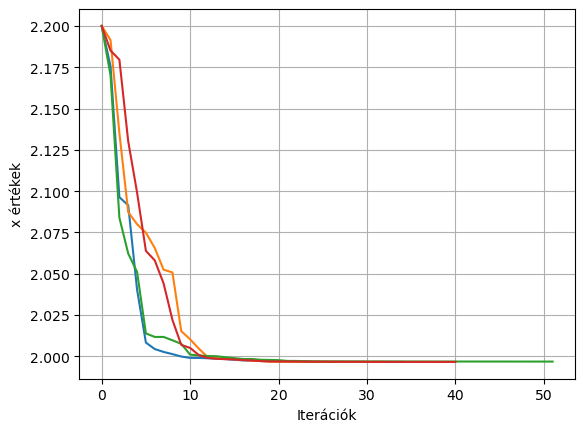

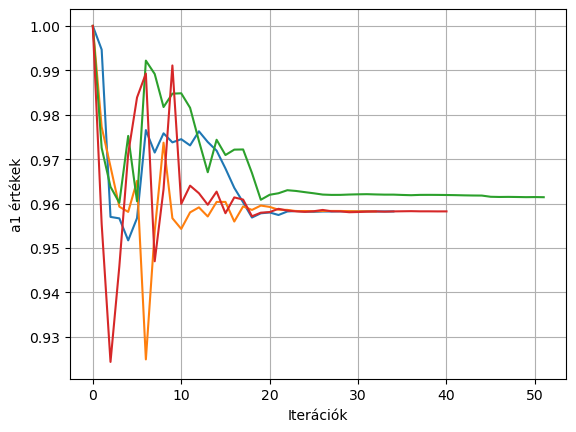

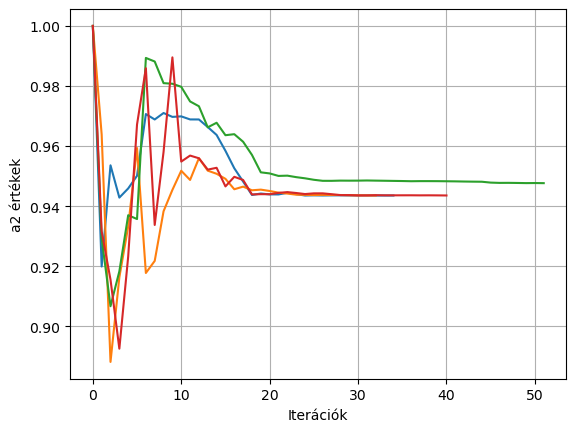

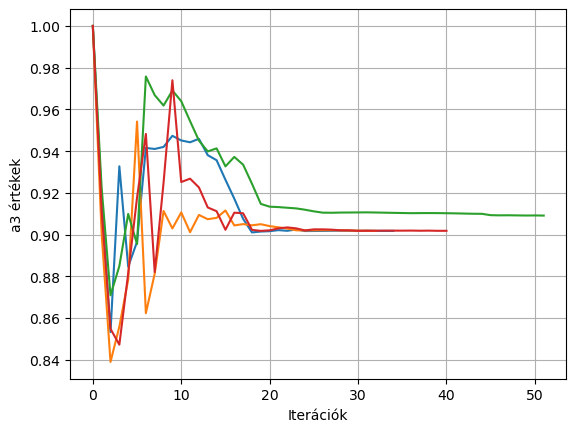

In [56]:
result=iteration(algorithmOri,perturb2,bestparam[0],bestparam[1],bestparam[2],bestparam[3],oriparameters,4,25,False)
print(result)
plotfunction(result)

Normális eloszlással

In [305]:
gyors=pretune([2.1,2.3,2.5],[0.01,0.1,1],[1e-2,1e-3,1e-4],[0.1,0.2,0.3],[1e3],algorithm3,cheOri,balance,perturb3,oriparameters)
gyors

[2.3, 0.1, 0.0001, 0.1, 1000.0, 1.9966496001921459]

In [289]:
bestparam=pretune([2.1,2.3,2.5],[0.01,0.1,1],[1e-2,1e-3,1e-4],[0.1,0.2,0.3],[1e4],algorithm3,cheOri,balance,perturb3,oriparameters)
bestparam

[2.5, 1, 0.0001, 0.1, 10000.0, 1.9966348712660735]

In [290]:
oriparameters[0]=bestparam[0]
result=iteration(algorithm3,perturb3,cheOri,balance,bestparam[1],bestparam[2],bestparam[3],bestparam[4],oriparameters,100,20,False)
print(result[0])

[1.9966311365986615, 0.9582321042182721, 0.94355761817882, 0.9017879597473355]


In [291]:
cheOri([1.9966312, 0.958234, 0.943555, 0.901789]) # a cikkben megírtakkal ez nem jön ki

False

In [301]:
print(cheOri([1.996631, 0.958232, 0.943557, 0.901787])) # de az itt kapott értékekkel igen

True


In [302]:
oriparameters[0]=bestparam[0]
result=iteration(algorithm3,perturb3,cheOri,balance,bestparam[1],bestparam[2],bestparam[3],bestparam[4],oriparameters,10,1,False)
print(result[0])

[1.9966335485314008, 0.9582310865765894, 0.9435583210902398, 0.9017840448094616]


#### Ezzel megkaptam a cikk optimális megoldását, pontosan: 1.996631...

## Eddig az egyszerű perturb2 működött a legjobban, de ezen talán lehet javítani
### Új perturb ötlet: d ne legyen fix minden változóhoz.

In [27]:
def perturb3(parameters, d, balance):
  outp=parameters.copy()
  outp[0]=parameters[0]+np.random.uniform(-d,0) # x-et külön kezeljük
  difference=[]
  return [outp,difference] # MEGVÁLTOZTATTAM IDEIGLENESEN!!!!!!!!!!!!
  for i in range(1,len(parameters)):
    modify1=np.random.normal(balance[i-1],d)
    modify2=np.random.normal(balance[i-1],d)
    if(modify1-modify2<2):
      diff=np.random.uniform(-d+modify1*d,d+modify2*d)
      outp[i]=parameters[i] + diff
      difference.append(diff*d)
    else:
      diff=np.random.uniform(-d+modify1/(modify1-modify2)*d,d+modify2/(modify1-modify2)*d)
      outp[i]=parameters[i] + diff
      difference.append(diff*d)
  return [outp,difference]

In [18]:
def algorithm3(parameters,perturb,check,balance, d, eps, delta, maxcnt,ifcnt0=True):
  outp=parameters.copy()
  plot=[]
  cnt = 0
  while(d>eps):
    tempw = perturb(outp, d, balance)
    temp=tempw[0]
    if (check(temp)):
      outp=temp.copy()
      plot.append(temp.copy())
      balance = [x + y for x, y in zip(balance, tempw[1])]
      if(ifcnt0==True): cnt= 0
    else: cnt+=1
    if(cnt >= maxcnt): d = d*delta; cnt = 0
  return [outp,plot,balance]

In [17]:
def pretunenew(x,d,eps,delta,maxcnt,alg,check,balance,perturb,param,ifplot=False,onlybestplot=False,ifcnt0=False):
    bestparam=[3]
    plots=[]
    for l in x:
      for i in d:
        for e in eps:
            for j in delta:
                for c in maxcnt:
                    param[0]=l
                    res=iterationnew(alg,perturb,check,balance,i,e,j,c,param,1,1,ifcnt0,onlybestplot)
                    if(ifplot):
                        if (res[0][0]<bestparam[-1]):
                            bestparam=[l,i,e,j,c,res[0][0]]
                            if (onlybestplot):
                                plots=res[2]
                        if(not onlybestplot):
                            plots.append(res[2])
                    else:
                        if (res[0][0]<bestparam[-1]):
                            bestparam=[l,i,e,j,c,res[0][0]]
    if(not ifplot):
        return bestparam
    else:
        return [bestparam,plots]

In [16]:
def iterationnew(algorithm,perturb,check,balance,d,eps,delta,maxcnt,parameters,out,ins,bool=True,onlybestplot=False):
  plots=[]
  if(onlybestplot):
    bests=[3]
  else:
    bests=[]
  for _ in range(out): # a külső ciklusban mindent újrakezdünk
    plot=[parameters]
    best=[3,0,0,0,0,0]
    bal=balance.copy()
    tpar=parameters.copy() # ne írja át mindig az eredeti változót
    for _ in range(ins): # a belső ciklusban az előző eredményből indulunk, ha az javított
      result=algorithm(tpar,perturb,check,bal, d, eps, delta, maxcnt,bool)
      if(result[0][0]<=best[0]): 
        plot= plot+result[1]
        best=result[0]
        tpar=best
        bal=result[2]
    # belső ciklus vége
    if(not onlybestplot): # ha nem csak a legjobb kell, akkor mindet feljegyezzük
      bests.append(best)
      plots.append(plot)
    else:
      if(best[0]<bests[0]):
        bests=best
        plots=plot
  # külső ciklus vége
  opt=[3]
  if(not onlybestplot):
    for i in bests:
      if(i[0]<opt[0]):opt=i
    return [opt,bests,plots]
  else:
    if(bests[0]<opt[0]):opt=bests
    return [opt,bests,[plots]]

# 3. Összehasonlítás
## 3.1. Saját feladat

In [77]:
parameters=[2,1,1,1,0,0]
names=["λ","alpha","beta","gamma","nu","mu"]
d=0.1
eps=1e-3
delta=0.2
maxcnt=1e4
parameters[0]=2.5
balance=[0]*(len(parameters)-1)

0. Program

In [78]:
# Pretunnal
bestparam=pretune([0.01,0.1,1],[1e-2,1e-3,1e-4],[0.1,0.2,0.3],[1e3],algorithm11,checkall,perturb1,parameters,True,True)
print(bestparam[0])
plot00=bestparam[1]

[0.01, 0.001, 0.1, 1000.0, 2.3338025499045965]


In [79]:
# Simán
result = iteration(algorithm11,perturb1,checkall,d,eps,delta,1e3,parameters,10,2,False,onlybestplot=True)
print(result[0])
plot0=result[2]

[2.192267043533862, 0.9968723373452485, 0.9553818319672074, 0.9203648303052735, 0.07517943095763072, 0.07557954925572649]


1. Program

In [80]:
# Pretunnal
bestparam=pretune([0.01,0.1,1],[1e-2,1e-3,1e-4],[0.1,0.2,0.3],[1e3],algorithm12,checkall,perturb2,parameters,True,True)
print(bestparam[0])
plot10=bestparam[1]

[0.1, 0.0001, 0.2, 1000.0, 1.9959417772082042]


In [81]:
# Simán
result = iteration(algorithm12,perturb2,checkall,d,eps,delta,1e3,parameters,10,2,False,onlybestplot=True)
print(result[0])
plot1=result[2]

[1.9962293207652844, 0.9583284784419274, 0.9445630269979212, 0.9023171308850781, 0.008357362036332862, 0.003652187562941247]


2. Program

In [90]:
# Pretunnal az egyesével randomizálás, ehhez új kezdőérték kell 
parameters=[2.5,0.99,0.98,0.97,0.001,0]
bestparam=pretune([0.01,0.1,1],[1e-2,1e-3,1e-4],[0.1,0.2,0.3],[1e3],algorithm21,checkall,perturbj,parameters,True,True)
print(bestparam[0])
plot210=bestparam[1]

[0.01, 0.0001, 0.3, 1000.0, 1.9984054201070933]


In [91]:
# Előző simán
result=iteration(algorithm21,perturbj,checkall,d,eps,delta,1e3,parameters,10,2,True,onlybestplot=True)
print(result[0])
plot21=result[2]

[1.9986020495469794, 0.9841901541398709, 0.9780262711592526, 0.9623253790922757, 0.005376866926747056, 0]


In [84]:
# Pretunnal a blokkos randomizálás
parameters=[2.5,1,1,1,0,0]
bestparam=pretune([0.01,0.1,1],[1e-2,1e-3,1e-4],[0.1,0.2,0.3],[1e3],algorithm22,checkall,perturbspecialchanges2,parameters,True,True)
print(bestparam[0])
plot220=bestparam[1]

[1, 0.001, 0.1, 1000.0, 1.9960087495334373]


In [85]:
# Előző simán
result=iteration(algorithm22,perturbspecialchanges2,checkall,d,eps,delta,1e3,parameters,10,2,False,onlybestplot=True)
print(result[0])
plot22=result[2]

[1.9960345690555863, 0.9588614429899827, 0.9451070835998335, 0.9038587668580693, 0.007794315036485984, 0.003815858759467364]


3. Program

In [86]:
# Pretunnal 
bestparam=pretunenew([2.4,2.5,2.6],[0.01,0.1,1],[1e-2,1e-3,1e-4],[0.1,0.2,0.3],[1e3],algorithm3,checkall,balance,perturb3,parameters,True,True)
print(bestparam[0])
plot30=bestparam[1]

[2.4, 0.1, 0.0001, 0.2, 1000.0, 1.995883035268594]


In [87]:
# Simán
result=iterationnew(algorithm3,perturb3,checkall,balance,d,eps,delta,1e3,parameters,10,2,False,onlybestplot=True)
print(result)
plot3=result[2]

[[1.9964969957133454, 0.9578680912328534, 0.945394655055682, 0.9045211199057642, 0.009215624644487412, 0.0031759541308665827], [1.9964969957133454, 0.9578680912328534, 0.945394655055682, 0.9045211199057642, 0.009215624644487412, 0.0031759541308665827], [[[2.6, 1, 1, 1, 0, 0], [2.5481536816200245, 0.9690436358477436, 0.9384304324118159, 0.9342757779699347, 0.02443103323276484, 0.010333172223768755], [2.4880020852105025, 0.9964215668343765, 0.9786552346422579, 0.9232661597177225, 0.11002197979738462, 0.04622848738234245], [2.444547207501303, 0.9916479794151096, 0.9006157213293025, 0.8734613947386036, 0.16268046590268007, 0.06934174677556225], [2.431597007591886, 0.9734238065768506, 0.8291726861218711, 0.8205615959330789, 0.1569697660188924, 0.12190549207972906], [2.380469616974417, 0.9705081436755671, 0.9096286632233951, 0.7400907966451071, 0.12862457571789626, 0.10837906565492346], [2.358430524007669, 0.9625503387807063, 0.8297862440102997, 0.7758958090313409, 0.14711722413398076, 0.053

Plot

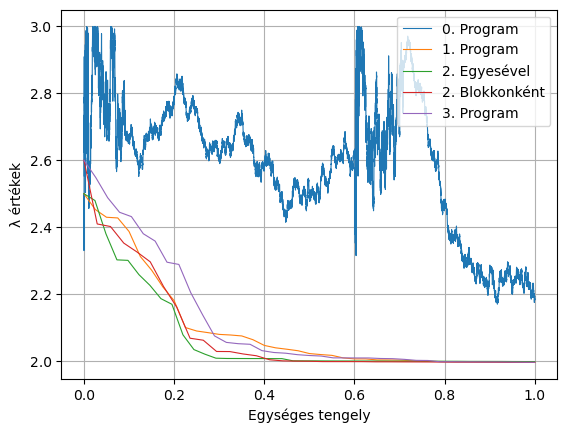

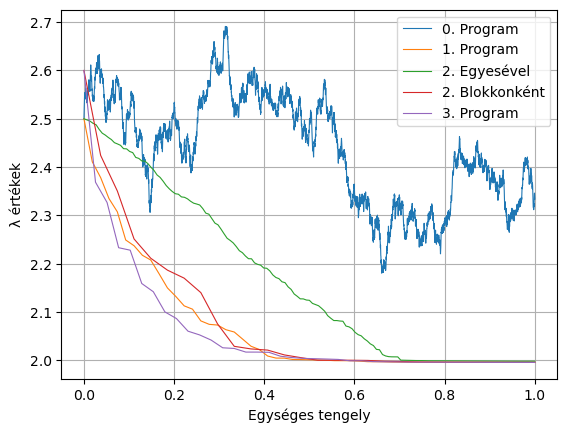

In [97]:
plotfunction(plot0+plot1+plot21+plot22+plot3,hynames=["0. Program","1. Program","2. Egyesével","2. Blokkonként","3. Program"])
plotfunction(plot00+plot10+plot210+plot220+plot30,hynames=["0. Program","1. Program","2. Egyesével","2. Blokkonként","3. Program"])

## 3.2. Eredeti feladat

In [97]:
balance=[0]*(len(oriparameters)-1)
result=iterationnew(algorithm3,perturb3,cheOri,balance,d,eps,delta,maxcnt,oriparameters,1,1,False)
print(result[0])

[1.996848388371962, 0.9582408250256962, 0.9444981017794382, 0.9032892975589873]


## 3.3. M&C

In [64]:
mparameters=[2,0,0.6,0.7,0.8,0.9,1,1,0,0.6,0.7,0.8,0.9,1]
names=["λ","a1","a2","a3","a4","a5","a6","a7","b1","b2","b3","b4","b5","b6"]
print(cheM(mparameters))

True


In [73]:
specpars=[0]+list(range(2,6))+list(range(9,13))
result = iteration(algorithm11,perturb1,cheM,d,eps,delta,1e3,mparameters,1,1,False,onlybestplot=True,specpars=specpars)
print(result[0])

[1.945567587970195, 0, 0.3792659273584792, 0.6327445087554647, 0.7607077984456522, 0.8848919311955866, 1, 1, 0, 0.22475496294852454, 0.48368392672487875, 0.6358345755459455, 0.8139029589859078, 1]


In [102]:
specpars=[0]+list(range(2,6))+list(range(9,13))
bestparam=pretune([0.01,0.1,1],[1e-2,1e-3,1e-4],[0.1,0.2,0.3],[1e3],algorithm11,cheM,perturb2,mparameters,ifplot=False,specpars=specpars)
result = iteration(algorithm11,perturb2,cheM,bestparam[0],bestparam[1],bestparam[2],1e3,mparameters,1,1,False,onlybestplot=True,specpars=specpars)
print(result[0])
plot1=result[2]

[1.2568150591198552, 0, 0.6098369011062518, 0.8805977568721223, 0.9683084589158352, 0.9999019788696548, 1, 1, 0, 0.40507377403567907, 0.7287034833074568, 0.87036417018025, 0.943406381115626, 1]


In [80]:
balance=[0]*(len(mparameters)-1)
prerune=pretunenew([2],[0.01,0.1,1],[1e-2,1e-3,1e-4],[0.1,0.2,0.3],[1e3],algorithm3,cheM,balance,perturbM,mparameters,ifplot=False)
result=iterationnew(algorithm3,perturbM,cheM,balance,prerune[1],prerune[2],prerune[3],1e3,mparameters,1,1,False,onlybestplot=True)
print(result[0])
plot3=result[2]

[1.2538238473873, 0, 0.420171835241431, 0.8353296894443839, 0.9625694110931123, 0.9982638750307777, 1, 1, 0, 0.3072588808698507, 0.6719604364189988, 0.9323104117041564, 0.971622982408712, 1]


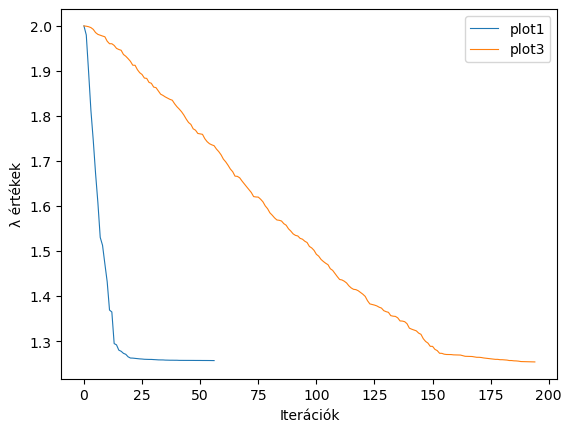

In [105]:
plotfunction(plot1+plot3,hynames=["plot1","plot3"])

# Hosszas futtatások

In [205]:
parameters=[2.5,1,1,1,0,0]
names=["λ","alpha","beta","gamma","nu","mu"]
d=0.1
eps=1e-3
delta=0.2
maxcnt=1e4

balance=[0]*(len(parameters)-1)
prerune=pretunenew([2.4,2.5,2.6],[0.01,0.1,1],[1e-2,1e-3,1e-4],[0.1,0.2,0.3],[1e3],algorithm3,checkall,balance,perturb3,parameters)
mparameters[0]=prerune[0]
result=iterationnew(algorithm3,perturb3,checkall,balance,prerune[1],prerune[2],prerune[3],prerune[4],parameters,100,15,False)
print(result[0])

[1.6180422676517559, 0.9999451515664087, 6.2752503011515536e-06, 3.4597213810010855e-06, 0.3316123370562783, 0.9999969648449504]


In [203]:
checkall([1.995839, 0.958218, 0.944115, 0.902332, 0.016377, 0.004020])

[7075913, 26287654, 11489762, 221, 3568, 395176, 1688359]

# 4. Elágazási faktorok

In [14]:
def checkone(j):
    return lambda temp:(0<=temp[0]<=3 and 0<=temp[1]<= 1 and 0<=temp[2] <= 1 and 0<=temp[3] <= 1 and 1>=temp[4] >= 0 and 1>=temp[5] >= 0 
      and temp[1] > temp[2] and temp[2] > temp[3] and branchingFactors(temp,j))
def branchingFactors(par,j):
  constrs=[(par[0]**(-par[1]+par[4]) + par[0]**(-(3-2*par[1])+par[4]) > 1),
  (par[0]**(-1+par[5]) + par[0]**(-(1+par[1]-par[2]-par[5])) > 1),
  (par[0]**(-1-par[5]) + par[0]**(-2) + par[0]**(-(2+par[1]-par[2])) > 1),
  (par[0]**(-1) + par[0]**(-2-par[5]) + par[0]**(-(2+par[1]-par[2])) > 1),
  (par[0]**(-1-par[4]) + par[0]**(-2) + par[0]**(-(2+par[1]-par[2])) > 1),
  (par[0]**(-par[3]) + par[0]**(-(par[3]+2*par[2])) > 1),
  (par[0]**(-par[3]) + par[0]**(-(par[3]+par[2])) + par[0]**(-(par[3]+3*par[2])) > 1),
  (par[0]**(-par[3]) + par[0]**(-(par[3]+par[2])) + par[0]**(-(par[3]+2*par[2])) + par[0]**(-(par[3]+4*par[2])) > 1),
  (par[0]**(-par[3]) + par[0]**(-(par[3]+5*min(1-par[1],par[2]-par[3]))) > 1)]
  if(constrs[j]): return False
  else:return True

In [28]:
parameters=[2.5,1,1,1,0,0]
names=["λ","alpha","beta","gamma","nu","mu"]
d=0.1
eps=1e-3
delta=0.2
maxcnt=1e4
parameters=[1.995839, 0.958218, 0.944115, 0.902332, 0.016377, 0.004020]

balance=[0]*(len(parameters)-1)
for j in range(9):
    prerune=pretunenew([1.995839],[0.01,0.1,1],[1e-2,1e-3,1e-4],[0.1,0.2,0.3],[1e3],algorithm3,checkone(j),balance,perturb3,parameters)
    parameters[0]=prerune[0]
    result=iterationnew(algorithm3,perturb3,checkone(j),balance,prerune[1],prerune[2],prerune[3],prerune[4],parameters,10,2,False)
    print(f"{j+1}. elágazási faktor: {result[0]}")

1. elágazási faktor: [1.995641457755375, 0.958218, 0.944115, 0.902332, 0.016377, 0.00402]
2. elágazási faktor: [1.9958381634203626, 0.958218, 0.944115, 0.902332, 0.016377, 0.00402]
3. elágazási faktor: [1.9949170774341125, 0.958218, 0.944115, 0.902332, 0.016377, 0.00402]
4. elágazási faktor: [1.9958365767592334, 0.958218, 0.944115, 0.902332, 0.016377, 0.00402]
5. elágazási faktor: [1.9893169954254146, 0.958218, 0.944115, 0.902332, 0.016377, 0.00402]
6. elágazási faktor: [1.5161368952290215, 0.958218, 0.944115, 0.902332, 0.016377, 0.00402]
7. elágazási faktor: [1.8446117897090724, 0.958218, 0.944115, 0.902332, 0.016377, 0.00402]
8. elágazási faktor: [1.9958048720731159, 0.958218, 0.944115, 0.902332, 0.016377, 0.00402]
9. elágazási faktor: [1.9958300157519862, 0.958218, 0.944115, 0.902332, 0.016377, 0.00402]
